In [26]:
# Before starting, execute those commands:
# pip install pandas_datareader
# pip install arch
# pip install autograd

In [4]:
import bs4 as bs
import datetime as dt
import matplotlib.pyplot as plt
from matplotlib import style
import numpy as np
import os
import pandas as pd
import pandas_datareader.data as web
import pickle
import requests
from scipy.stats import kurtosis
from scipy.stats import skew
from statsmodels.tsa.arima_model import ARIMA
import arch

style.use('ggplot')

In [5]:
def stds(array, df_corr, df):
    for i in df_corr.index:
        array.append(df[i].std())
    return array

def means(array, df_corr, df):
    for i in df_corr.index:
        array.append(df[i].mean())
    return array

In [6]:
# These functions for importing S&P500 indexes used from Youtube tutorial by sentdex: 
# https://www.youtube.com/watch?v=2BrpKpWwT2A&list=PLQVvvaa0QuDcOdF96TBtRtuQksErCEBYZ

def save_sp500_tickers():
    resp = requests.get('https://en.wikipedia.org/wiki/List_of_S%26P_500_companies')
    soup = bs.BeautifulSoup(resp.text, 'lxml')
    table = soup.find('table', {'id':'constituents'})
    tickers = []
    for row in table.findAll('tr')[1:]:
        #ticker = row.find('td').text
        #tickers.append(ticker)
        ticker = row.find_all('td')[0].text.replace('\n','')
        if "." in ticker:
            ticker = ticker.replace('.','-')
            print('ticker replaced to', ticker) 
        tickers.append(ticker)
        
    with open("sp500tickers.pickle", "wb") as f:
        pickle.dump(tickers, f)

    return tickers

save_sp500_tickers()

def get_data_from_yahoo(reload_sp500=False):
    if reload_sp500:
        tickers = save_sp500_tickers()
    else:
        with open("sp500tickers.pickle", "rb") as f:
            tickers = pickle.load(f)
    
    if not os.path.exists('stock_dfs'):
        os.makedirs('stock_dfs')
        
    start = dt.datetime(2000,1,1)
    end = dt.datetime(2020,10,28)
    
    for ticker in tickers:
        if not os.path.exists('stock_dfs/{}.csv'.format(ticker)):
            df = web.DataReader(ticker, 'yahoo', start, end)
            df.to_csv('stock_dfs/{}.csv'.format(ticker))
        else:
            print('Already have {}'.format(ticker))

            
get_data_from_yahoo()

def compile_data():
    with open("sp500tickers.pickle","rb") as f:
        tickers = pickle.load(f)
        
    main_df = pd.DataFrame()
    
    for count, ticker in enumerate(tickers):
        df = pd.read_csv('stock_dfs/{}.csv'.format(ticker.replace('.','-')))
        df.set_index('Date', inplace=True)
        
        df.rename(columns = {'Adj Close':ticker}, inplace=True)
        # palikti high low
        df.drop(['Open', 'High', 'Low', 'Close', 'Volume'], 1, inplace=True)
        
        if main_df.empty:
            main_df = df
        else:
            main_df = main_df.join(df, how='outer')
            
        if count % 10 == 0:
            print(count)
    
    #print(main_df.head())
    main_df.to_csv('sp500_joined_closes.csv')
    
compile_data()
   
def visualize_data():
    df = pd.read_csv('sp500_joined_closes.csv')
    #df['AAPL'].plot()
    #plt.show()
    df_corr = df.corr()
    
    #print(df_corr)
    
    data = df_corr.values
    fig = plt.figure()
    ax = fig.add_subplot(1,1,1)
    
    heatmap = ax.pcolor(data, cmap=plt.cm.RdYlGn)
    fig.colorbar(heatmap)
    ax.set_xticks(np.arange(data.shape[0]) + 0.5, minor=False)
    ax.set_yticks(np.arange(data.shape[1]) + 0.5, minor=False)
    ax.invert_yaxis()
    ax.xaxis.tick_top()
    
    column_labels = df_corr.columns
    row_labels = df_corr.index
    
    ax.set_xticklabels(column_labels)
    ax.set_yticklabels(row_labels)
    plt.xticks(rotation=90)
    heatmap.set_clim(-1, 1)
    plt.tight_layout()
    plt.show()
    
#visualize_data()

In [148]:
start = '2019-05-01'
end = '2019-08-09'

sp500 = web.DataReader('^GSPC', 'yahoo', start, end)
dataF = pd.read_csv('sp500_joined_closes.csv')
dataF = dataF.set_index(dataF['Date'])
dataF = dataF.drop(columns='Date')
dataF = dataF[start:end]
dataF = dataF.dropna(1)
# transform prices to returns
dataF = np.log(dataF / dataF.shift(1))
# removes the first day
dataF = dataF.dropna()

# change index to 0, 1, ...
dataF = dataF.reset_index()
dataF = dataF.drop(columns='Date')

# adding sp500 returns to the dataframe
dataF['SP500'] = np.log(sp500['Adj Close'] / sp500['Adj Close'].shift(1))[1:].values

# Values closest to 0 (least correlated with SP500) pass the filter
sp500_corr = dataF.corr()['SP500']
sp500_leastcorr = sp500_corr.where((sp500_corr > -0.11) & (sp500_corr < 0.11)).dropna()

# Dataframe with one column:
# Least correlated stocks' returns correlation with sp500 returns
leastcorr_df = pd.DataFrame(sp500_leastcorr)

leastcorr_df['stds'] = stds([], sp500_leastcorr, dataF)
leastcorr_df['cov'] = leastcorr_df['SP500'] / (dataF['SP500'].std() * leastcorr_df['stds'])
leastcorr_df['beta'] = leastcorr_df['cov'] / dataF['SP500'].var()
leastcorr_df['means'] = means([], sp500_leastcorr, dataF)
#leastcorr_df['kurtosis'] = kurtosis()

lc_stocks = web.DataReader(sp500_leastcorr.index.values, 'yahoo', start, end)

# Least correlated stocks' log(high) - log(low)
lc_volatility = pd.DataFrame(np.log(lc_stocks['High']) - np.log(lc_stocks['Low']))
lc_volatility['SP500'] = (np.log(sp500['High']) - np.log(sp500['Low'])).values


# Out of those chosen ones, least correlated stocks with each other
lc_returns_corr = dataF[sp500_leastcorr.index.values].corr()
lc_returns_corr = lc_returns_corr.where((lc_returns_corr > -0.3) & (lc_returns_corr < 0.3))

# thresh - required not NaN values
# Out of chosen stocks, 
# we determine which ones has the most not NaN (about 90% of not NaN of the size of previous filtered stocks) correlations with others
most_corr = lc_returns_corr.dropna(thresh=round(lc_returns_corr.shape[0] * 0.9))
mostcorr_df = dataF[most_corr.index]

# kurtosis and skew for stocks that went through two least correlation filters
kurtosis_df = pd.DataFrame(kurtosis(mostcorr_df), columns=['kurtosis'], index=mostcorr_df.columns)
skew_df = pd.DataFrame(skew(mostcorr_df), columns=['skew'], index=mostcorr_df.columns)

# least correlated stocks volatility correlation with SP500
volatility_corr = lc_volatility.corr()['SP500']

# most correlated volatility
# volatility_corr.where((volatility_corr > -0.4) & (volatility_corr < 0.4)).dropna()

In [8]:
def covariance_matrix(data):
    
    def covariance(x, y):
        T = len(x)
        d = 1.005
        cumsum = 0
        for day in x.index.values:
            cumsum += d ** day *(x.iloc[day] - x.mean()) * (y.iloc[day] - y.mean())
        return cumsum * (2 - d) / T
    
    matrix = pd.DataFrame(np.arange(len(data.columns)**2).reshape(len(data.columns), len(data.columns)), 
                          columns=data.columns.values, index=data.columns.values, dtype=float)
    
    for i in matrix:
        for j in matrix:
            matrix[i][j] = covariance(data[i], data[j])
    return matrix


In [9]:
def generate_U_matrix(data):
    matrix = np.zeros((len(data.columns), len(data.columns)))
    for i, stock_i in enumerate(data.columns):
        for j, stock_j in enumerate(data.columns):
            matrix[i][j] = 0.25 * ((data[stock_i] + data[stock_j]).var() -  (data[stock_i] - data[stock_j]).var())
    return matrix

In [10]:
cov_matrix = covariance_matrix(dataF[most_corr.index])
diag_values = np.diag(cov_matrix)

# cov diagonal
zeros = np.zeros_like(cov_matrix)
np.fill_diagonal(zeros, diag_values)
cov_diag = pd.DataFrame(zeros, columns=most_corr.index, index=most_corr.index)

# cov ** -1 diagonal
zeros = np.zeros_like(cov_matrix)
np.fill_diagonal(zeros, np.diag((cov_diag ** -1)))
cov_inv_diag = pd.DataFrame(zeros, columns=most_corr.index, index=most_corr.index)

# x over t
x_over_t = dataF[most_corr.index] * cov_inv_diag.sum()
U_matrix_values = generate_U_matrix(x_over_t)
U_matrix = pd.DataFrame(U_matrix_values, index=x_over_t.columns, columns=x_over_t.columns)
np.fill_diagonal(U_matrix.values, np.ones(most_corr.index.size))
U_matrix_eigen = np.linalg.eig(U_matrix)

# z over t
z_over_t = np.matmul(U_matrix_eigen[1].T, x_over_t.T)
z_over_t_var = z_over_t.T.var()
zeros = np.zeros_like(cov_matrix)
np.fill_diagonal(zeros, z_over_t_var)
gamma_matrix = pd.DataFrame(zeros, columns=most_corr.index, index=most_corr.index)

# AE
AE = np.matmul(cov_diag, U_matrix_eigen[1])
robust_cov_matrix = np.matmul(np.matmul(AE, gamma_matrix), AE.T)

# Black Literman - UNFINISHED
q_matrix = np.array([[0.0015], [0.004]])
p_matrix = np.zeros((2, most_corr.index.size))
p_matrix[0][0] = 1.0
p_matrix[1][1] = -1.0
p_matrix[1][2] = 1.0
omega_matrix = np.array([[0.0004, 0], [0, 0.0016]])
inv_omega_matrix = omega_matrix ** -1
inv_omega_matrix[0][1], inv_omega_matrix[1, 0] = (0, 0)
t = 0.15
means_matrix = np.array(mostcorr_df.mean().values).reshape(most_corr.index.size, 1)
blackLitterman_mean1 = ((t * robust_cov_matrix) ** -1 + np.matmul(np.matmul(p_matrix.T, inv_omega_matrix), p_matrix)) ** -1
blackLitterman_mean2 = np.matmul((t * robust_cov_matrix).values ** -1, means_matrix) + np.matmul(np.matmul(p_matrix.T, inv_omega_matrix), q_matrix)
blackLitterman_mean = np.matmul(blackLitterman_mean1.values, blackLitterman_mean2)

<ipython-input-10-56eb3ac4322f>:39: RuntimeWarning: divide by zero encountered in reciprocal
  inv_omega_matrix = omega_matrix ** -1


In [11]:
# Calculating the minimum variance portfolio

# The template for those function was taken from:
# https://kitchingroup.cheme.cmu.edu/blog/2018/11/03/Constrained-optimization-with-Lagrange-multipliers-and-autograd/

import autograd.numpy as np
from autograd import grad

def objective(X):
    w1, w2, w3, w4, w5, w6 = ((cov_matrix * pd.Series(X)[:, np.newaxis]).sum() * X).values
    return w1 + w2 + w3 + w4 + w5 + w6

def eq(X):
    w1, w2, w3, w4, w5, w6 = X
    return w1 + w2 + w3 + w4 + w5 + w6 - 1

def F(L):
    'Augmented Lagrange function'
    w1, w2, w3, w4, w5, w6, _lambda = L
    return objective([w1, w2, w3, w4, w5, w6]) - _lambda * eq([w1, w2, w3, w4, w5, w6])

# Gradients of the Lagrange function
dfdL = grad(F, 0)

# Find L that returns all zeros in this function.
def obj(L):
    w1, w2, w3, w4, w5, w6, _lambda = L
    dFdw1, dFdw2, dFdw3, dFdw4, dFdw5, dFdw6, dFdlam = dfdL(L)
    return [dFdw1, dFdw2, dFdw3, dFdw4, dFdw5, dFdw6, eq([w1, w2, w3, w4, w5, w6])]

from scipy.optimize import fsolve

w1, w2, w3, w4, w5, w6, _lam = fsolve(obj, [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0])
print(f'The answer is at {w1, w2, w3, w4, w5, w6}')

weights = pd.Series([w1, w2, w3, w4, w5, w6])

The answer is at (0.13534257918068934, 0.06672632058638708, 0.12368638815970663, 0.3093077568358499, 0.21903735129150956, 0.14589960394585746)


<ipython-input-11-de76a8a3749b>:10: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  w1, w2, w3, w4, w5, w6 = ((cov_matrix * pd.Series(X)[:, np.newaxis]).sum() * X).values


In [59]:
pip install cvxopt

Note: you may need to restart the kernel to use updated packages.


In [63]:
mostcorr_df.mean()

CAG    -0.000391
ENPH    0.015736
IFF    -0.004795
LW      0.002112
MKTX    0.001509
MHK    -0.005678
dtype: float64

In [95]:
from cvxopt import matrix

P = matrix(cov_matrix.values * (-1), tc='d')

q = matrix(mostcorr_df.mean().values, tc='d')

G_matrix = np.zeros((6, 6))
np.fill_diagonal(G_matrix, np.ones(6) * (-1))
G = matrix(G_matrix, tc='d')

h = matrix(np.zeros((6, 1)), tc='d')

A = matrix(np.ones((1, 6)), tc='d')

b = matrix(np.ones((1, 1)), tc='d')

In [108]:
from cvxopt import solvers
sol = solvers.qp(P, q, G, h, A, b)
solutions = np.array([solution for solution in sol['x']])

     pcost       dcost       gap    pres   dres
 0:  1.0324e-03 -1.0058e+00  1e+00  4e-16  3e+00
 1:  9.4288e-04 -1.5762e-02  2e-02  1e-16  5e-02
 2: -2.0413e-03 -6.0142e-03  4e-03  1e-16  1e-02
Terminated (singular KKT matrix).


In [120]:
model = ARIMA(mostcorr_df['CAG'][:35], order=(1,0,1))
model_fit = model.fit(disp=0)

volatility = []
for i in range(35):  
    volatility.append((mostcorr_df['CAG'][:35 + i].std() * (1 + (model_fit.maparams ** 2) + 2 * 
                                              model_fit.maparams * model_fit.arparams)) / (1 - (model_fit.arparams ** 2)))
model_summary = model_fit.summary()

C:\Users\Win10\anaconda3\lib\site-packages\statsmodels\tsa\arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)


In [54]:
# CAG stock model
one_stock = np.log(web.DataReader("CAG", 'yahoo', start, end))

variance_0 = (one_stock.Close - one_stock.Close.shift(1)) ** 2
f = 0.645
variance_1 = ((one_stock.Open - one_stock.Close.shift(1)) ** 2) / f
variance_2 = ((one_stock.Close - one_stock.Open) ** 2) / (1 - f)
variance_3 = ((one_stock.High - one_stock.Low) ** 2) / (4 * np.log(2))
a = 0.17
variance_4 = a * variance_1 + (1 - a) * variance_3
variance_star = 0.5 * variance_1 + 0.5 * variance_2

up = (one_stock.High - one_stock.Open)
down = (one_stock.Low - one_stock.Open)
constant = (one_stock.Close - one_stock.Open)

double_star = 0.511 * ((up - down) ** 2) - 0.019 * (constant * (up + down) - 2 * up * down) - 0.383 * (constant ** 2)

variance_gk = a * variance_1 + (1 - a) * (double_star / (1 - f))

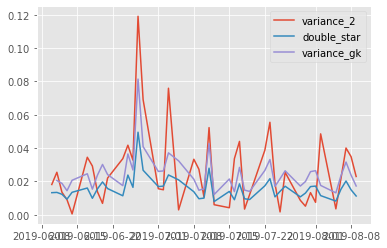

In [50]:
#plt.plot(variance_0, label="variance_0")
#plt.plot(variance_1, label="variance_1")
plt.plot(np.sqrt(variance_2), label="variance_2")
#plt.plot(variance_3, label="variance_3")
#plt.plot(variance_4, label="variance_4")
#plt.plot(variance_star, label="variance_star")
plt.plot(np.sqrt(double_star), label="double_star")
plt.plot(np.sqrt(variance_gk), label="variance_gk")

plt.legend()

In [56]:
model_summary

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:                    CAG   No. Observations:                   35
Model:                     ARMA(1, 1)   Log Likelihood                  75.949
Method:                       css-mle   S.D. of innovations              0.028
Date:                Sun, 07 Feb 2021   AIC                           -143.899
Time:                        18:23:49   BIC                           -137.677
Sample:                             0   HQIC                          -141.751
                                                                              
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0004      0.002     -0.150      0.881      -0.005       0.004
ar.L1.CAG      0.3439      0.402      0.855      0.393      -0.444       1.132
ma.L1.CAG     -0.6751      0.326     -2.072      0.038      -1.314      -0.036
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            2.9080           +0.0000j            2.9080            0.0000
MA.1            1.4813           +0.0000j            1.4813            0.0000
-----------------------------------------------------------------------------
"""

In [28]:
# model using arch
arch_model = arch.arch_model(mostcorr_df['CAG'])
arch_model.fit()

In [46]:
# stocks mean with weights
(mostcorr_df.mean().values * weights).sum()

-0.00038176085157177314

In [50]:
# stocks volatility with weights
(((cov_matrix * pd.Series(weights.values)[:, np.newaxis]).sum() * weights.values).values).sum()

0.0001616453182055078

<ipython-input-54-5e529719aea3>:2: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  np.sqrt((((cov_matrix * pd.Series(weights.values)[:, np.newaxis]).sum() * weights.values).values).sum()))


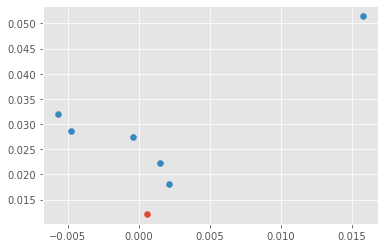

In [54]:
# Plotting stocks' and portfolio standard deviation on returns axis
plt.scatter((mostcorr_df.mean().values * weights).sum(), 
            np.sqrt((((cov_matrix * pd.Series(weights.values)[:, np.newaxis]).sum() * weights.values).values).sum()))
plt.scatter(mostcorr_df.mean().values, mostcorr_df.std().values)

<ipython-input-118-460a521d24b8>:2: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  np.sqrt((((cov_matrix * pd.Series(solutions)[:, np.newaxis]).sum() * solutions)).sum()))


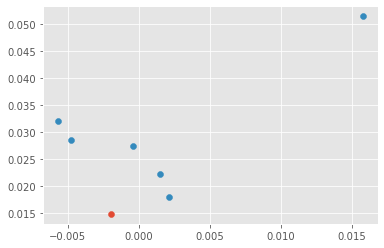

In [118]:
plt.scatter((mostcorr_df.mean().values * solutions).sum(), 
            np.sqrt((((cov_matrix * pd.Series(solutions)[:, np.newaxis]).sum() * solutions)).sum()))
plt.scatter(mostcorr_df.mean().values, mostcorr_df.std().values)